# Problem Statement


WHO is a specialized agency of the UN which is concerned with the world population health. Based upon the various parameters, WHO allocates budget for various areas to conduct various campaigns/initiatives to improve healthcare. Annual salary is an important variable which is considered to decide budget to be allocated for an area.  
  
We have a data which contains information about 32561 samples and 15 continuous and categorical variables. Extraction of data was done from 1994 Census dataset.  
  
The goal here is to build a binary model to predict whether the salary is >50K or <50K.

## Data Dictionary

1. <b>age:</b> age  
2. <b>workclass:</b> workclass  
3. <b>education:</b> highest education  
4. <b>marrital status:</b> marital status  
5. <b>occupation:</b> occupation  
6. <b>sex:</b> sex  
7. <b>capital gain:</b> income from investment sources other than salary/wages  
8. <b>capital loss:</b> income from investment sources other than salary/wages  
9. <b>working hours:</b> number of working hours per week  
10. <b>salary:</b> salary  

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt   
import seaborn as sns
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, classification_report, confusion_matrix, plot_confusion_matrix, plot_roc_curve

In [2]:
adult_data=pd.read_csv("adult.data.csv")

### EDA

In [3]:
adult_data.shape

(32561, 10)

In [4]:
adult_data.head()

,age,workclass,education,marrital status,occupation,sex,capital gain,capital loss,working hours per week,salary
0,39,State-gov,Bachelors,Never-married,Adm-clerical,Male,2174,0,40,<=50K
1,50,Self-emp-not-inc,Bachelors,Married-civ-spouse,Exec-managerial,Male,0,0,13,<=50K
2,38,Private,HS-grad,Divorced,Handlers-cleaners,Male,0,0,40,<=50K
3,53,Private,11th,Married-civ-spouse,Handlers-cleaners,Male,0,0,40,<=50K
4,28,Private,Bachelors,Married-civ-spouse,Prof-specialty,Female,0,0,40,<=50K


In [5]:
adult_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   age                     32561 non-null  int64 
 1   workclass               32561 non-null  object
 2   education               32561 non-null  object
 3   marrital status         32561 non-null  object
 4   occupation              32561 non-null  object
 5   sex                     32561 non-null  object
 6   capital gain            32561 non-null  int64 
 7   capital loss            32561 non-null  int64 
 8   working hours per week  32561 non-null  int64 
 9   salary                  32561 non-null  object
dtypes: int64(4), object(6)
memory usage: 2.5+ MB


There are no missing values. 6 variables are numeric and remaining categorical. Categorical variables are not in encoded format

### Check for duplicate data

In [6]:
dups = adult_data.duplicated()
print('Number of duplicate rows = %d' % (dups.sum()))
print(adult_data.shape)

Number of duplicate rows = 5864
(32561, 10)


In [7]:
adult_data.drop_duplicates(inplace=True) 

In [8]:
dups = adult_data.duplicated()
print('Number of duplicate rows = %d' % (dups.sum()))
print(adult_data.shape)

Number of duplicate rows = 0
(26697, 10)


### Geting unique counts of all Objects

In [9]:
for feature in adult_data.columns: 
    if adult_data[feature].dtype == 'object': 
        print(feature, ' Number of Levels', adult_data[feature].nunique())
        print(adult_data[feature].value_counts())
        print('\n')
        

workclass  Number of Levels 9
Private             17474
Self-emp-not-inc     2447
Local-gov            1980
?                    1519
State-gov            1246
Self-emp-inc         1089
Federal-gov           921
Without-pay            14
Never-worked            7
Name: workclass, dtype: int64


education  Number of Levels 16
HS-grad         7815
Some-college    5692
Bachelors       4461
Masters         1606
Assoc-voc       1281
Assoc-acdm      1036
11th             987
10th             820
7th-8th          611
Prof-school      562
9th              502
Doctorate        399
12th             397
5th-6th          315
1st-4th          164
Preschool         49
Name: education, dtype: int64


marrital status  Number of Levels 7
Married-civ-spouse       12679
Never-married             7698
Divorced                  3930
Separated                  978
Widowed                    971
Married-spouse-absent      418
Married-AF-spouse           23
Name: marrital status, dtype: int64


occupation  Nu

'workclass' and 'occupation' has ?  
Since, high number of cases have ?, we will convert them into a new level

In [10]:
# Replace ? to new Unk category

adult_data.workclass = np.where(adult_data.workclass=='?',
                                'Unk',adult_data.workclass)
adult_data.occupation = np.where(adult_data.occupation=='?',
                                'Unk', adult_data.occupation)

In [11]:
adult_data.workclass.value_counts() # sample check to see if ? is replaced

Private             17474
Self-emp-not-inc     2447
Local-gov            1980
Unk                  1519
State-gov            1246
Self-emp-inc         1089
Federal-gov           921
Without-pay            14
Never-worked            7
Name: workclass, dtype: int64

In [12]:
adult_data.occupation.value_counts()

Prof-specialty       3703
Exec-managerial      3531
Sales                3009
Craft-repair         2970
Adm-clerical         2884
Other-service        2626
Unk                  1526
Machine-op-inspct    1483
Transport-moving     1372
Handlers-cleaners    1033
Farming-fishing       951
Tech-support          841
Protective-serv       614
Priv-house-serv       145
Armed-Forces            9
Name: occupation, dtype: int64

In [ ]:
# Replace ? to new Unk category - Alternate Code

# adult_data.workclass=adult_data.workclass.str.replace('?', 'Unk')
# adult_data.occupation = adult_data.occupation.str.replace('?', 'Unk')

In [13]:
adult_data.describe().T.round(0)

,count,mean,std,min,25%,50%,75%,max
age,26697.0,40.0,14.0,17.0,29.0,39.0,49.0,90.0
capital gain,26697.0,1305.0,8111.0,0.0,0.0,0.0,0.0,99999.0
capital loss,26697.0,106.0,441.0,0.0,0.0,0.0,0.0,4356.0
working hours per week,26697.0,41.0,13.0,1.0,38.0,40.0,46.0,99.0


### Checking the spread of the data using boxplot for the continuous variables.

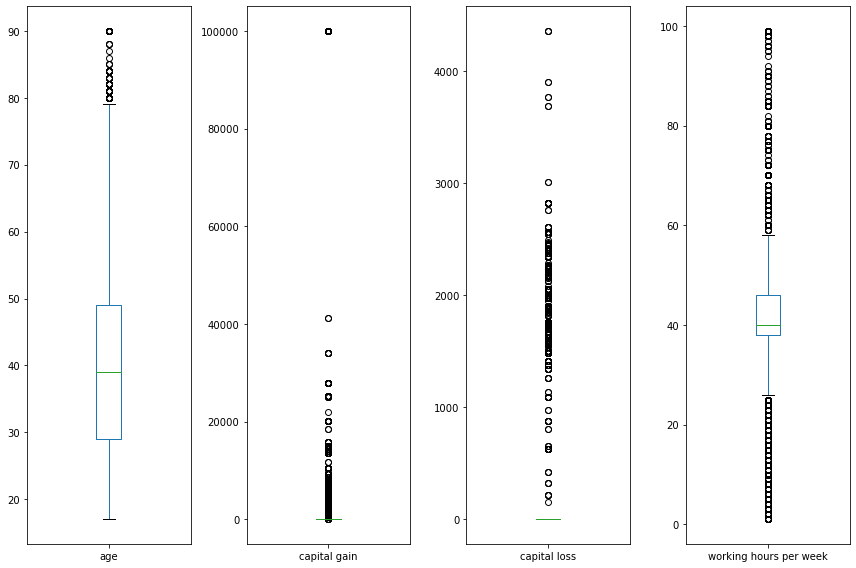

In [14]:
cols = ['age','capital gain','capital loss','working hours per week']
adult_data[cols].plot(kind = 'box',subplots=True, figsize = (12,8));
plt.tight_layout();

In [ ]:
# for i in cols:
#     sns.boxplot(adult_data[i],whis=1.5)
#     plt.grid()
#     plt.show();

### Treating the outliers.
###### We can treat Outliers with the following code. We will treat the outliers for the 'Working Hours per week' variable only.

In [15]:
def remove_outlier(col):
    sorted(col)
    Q1,Q3=np.percentile(col,[25,75])
    IQR=Q3-Q1
    lower_range= Q1-(1.5 * IQR)
    upper_range= Q3+(1.5 * IQR)
    return lower_range, upper_range

In [16]:
lr,ur=remove_outlier(adult_data['working hours per week'])
print('Lower Range :',lr,'\nUpper Range :',ur)
adult_data['working hours per week']=np.where(adult_data['working hours per week']>ur,ur,adult_data['working hours per week'])
adult_data['working hours per week']=np.where(adult_data['working hours per week']<lr,lr,adult_data['working hours per week'])

Lower Range : 26.0 
Upper Range : 58.0


In [ ]:
## This is a loop to treat outliers for all the non-'object' type varible

# for column in adult_data.columns:
#     if adult_data[column].dtype != 'object': 
#         lr,ur=remove_outlier(adult_data[column])
#         adult_data[column]=np.where(adult_data[column]>ur,ur,adult_data[column])
#         adult_data[column]=np.where(adult_data[column]<lr,lr,adult_data[column])

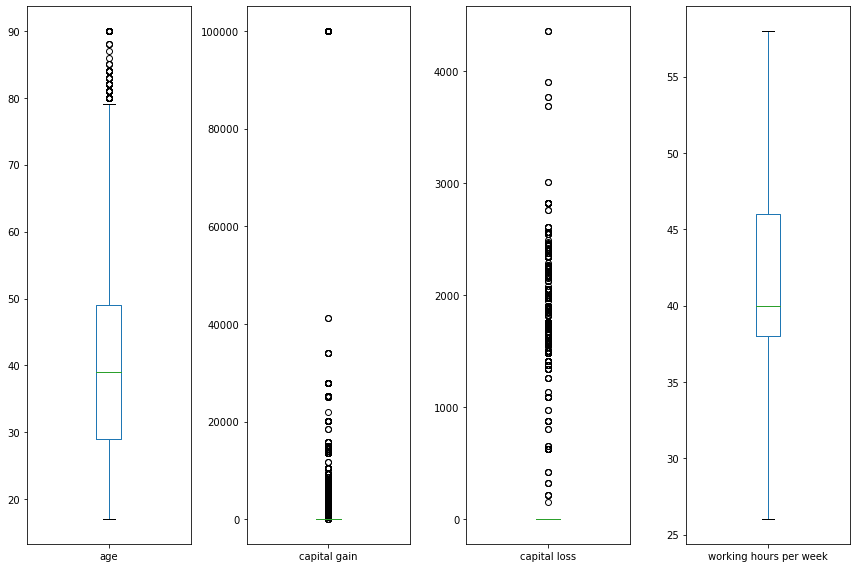

In [17]:
adult_data[cols].plot(kind = 'box',subplots=True, figsize = (12,8));
plt.tight_layout();

In [ ]:
# sns.displot(data = adult_data, x = 'capital gain', kind = 'kde', hue='salary');

### Checking for Correlations.

In [18]:
adult_data.corr().round(2)

,age,capital gain,capital loss,working hours per week
age,1.00,0.07,0.04,0.04
capital gain,0.07,1.00,-0.04,0.09
capital loss,0.04,-0.04,1.00,0.06
working hours per week,0.04,0.09,0.06,1.00


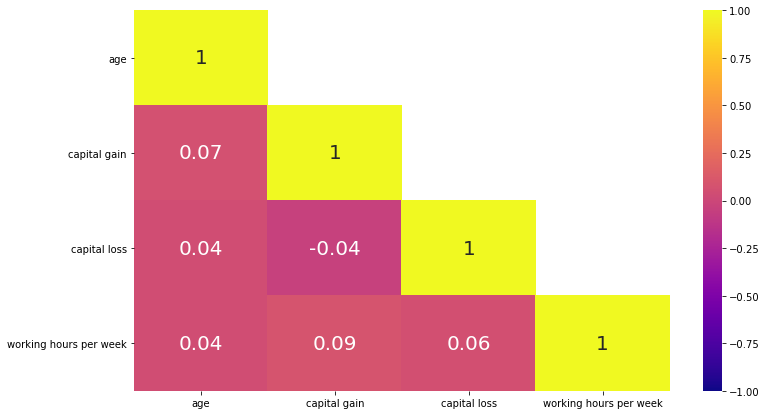

In [19]:
plt.figure(figsize=(12,7))
sns.heatmap(adult_data.corr().round(2), cmap='plasma', vmin=-1, 
            vmax=1, annot=True,
            annot_kws={'size':20},
            mask=np.triu(adult_data.corr(),+1))
plt.yticks(rotation = 0);

There is hardly any correlation between the numeric variables

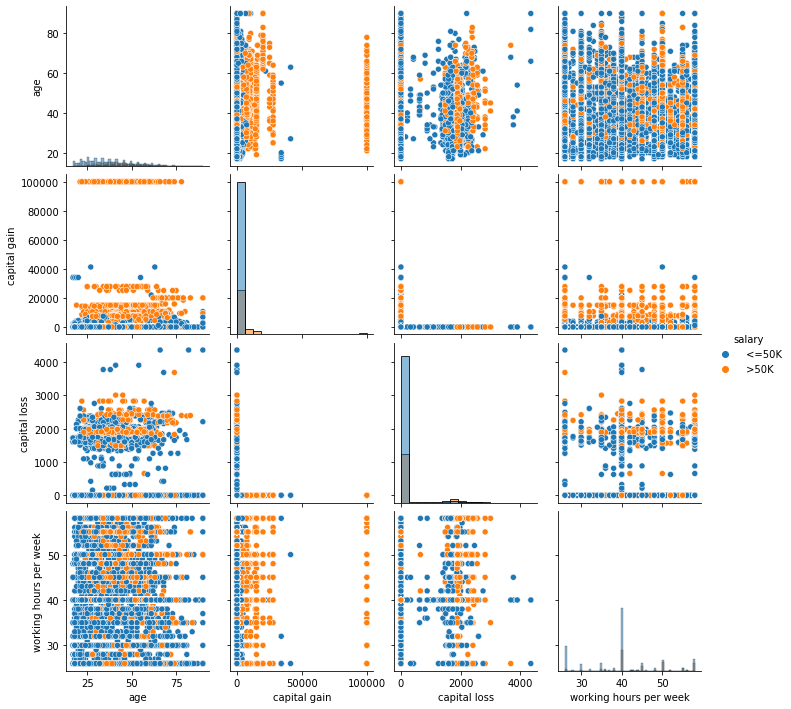

In [20]:
# Pairplot using sns
sns.pairplot(adult_data ,diag_kind='hist' ,hue='salary');

### Converting all objects to categorical codes

In [21]:
## We are coding up the 'education' variable in an ordinal manner Otherwise, if we just do Label encoding the numbering would be on alphabetic order basis or sequence in which the category labels appear in the rows

adult_data['education']=np.where(adult_data['education'] =='Preschool', '1', adult_data['education'])
adult_data['education']=np.where(adult_data['education'] =='1st-4th', '2', adult_data['education'])
adult_data['education']=np.where(adult_data['education'] =='5th-6th', '3', adult_data['education'])
adult_data['education']=np.where(adult_data['education'] =='7th-8th', '4', adult_data['education'])
adult_data['education']=np.where(adult_data['education'] =='9th', '5', adult_data['education'])
adult_data['education']=np.where(adult_data['education'] =='10th', '6', adult_data['education'])
adult_data['education']=np.where(adult_data['education'] =='11th', '7', adult_data['education'])
adult_data['education']=np.where(adult_data['education'] =='12th', '8', adult_data['education'])
adult_data['education']=np.where(adult_data['education'] =='HS-grad', '9', adult_data['education'])
adult_data['education']=np.where(adult_data['education'] =='Prof-school', '9', adult_data['education'])
adult_data['education']=np.where(adult_data['education'] =='Assoc-acdm', '10', adult_data['education'])
adult_data['education']=np.where(adult_data['education'] =='Assoc-voc', '11', adult_data['education'])
adult_data['education']=np.where(adult_data['education'] =='Some-college', '12', adult_data['education'])
adult_data['education']=np.where(adult_data['education'] =='Bachelors', '13', adult_data['education'])
adult_data['education']=np.where(adult_data['education'] =='Masters', '14', adult_data['education'])
adult_data['education']=np.where(adult_data['education'] =='Doctorate', '15', adult_data['education'])

In [22]:
## We are grouping certain types of 'workclass' under different categories

adult_data['workclass']=np.where(adult_data['workclass'] =='Federal-gov', 'Government', adult_data['workclass'])
adult_data['workclass']=np.where(adult_data['workclass'] =='Local-gov', 'Government', adult_data['workclass'])
adult_data['workclass']=np.where(adult_data['workclass'] =='State-gov', 'Government', adult_data['workclass'])

adult_data['workclass']=np.where(adult_data['workclass'] =='Self-emp-inc', 'Others', adult_data['workclass'])
adult_data['workclass']=np.where(adult_data['workclass'] =='Self-emp-not-inc', 'Others', adult_data['workclass'])
adult_data['workclass']=np.where(adult_data['workclass'] =='Unk', 'Others', adult_data['workclass'])
adult_data['workclass']=np.where(adult_data['workclass'] =='Without-pay', 'Others', adult_data['workclass'])
adult_data['workclass']=np.where(adult_data['workclass'] =='Never-worked', 'Others', adult_data['workclass'])

In [23]:
## We are grouping certain types of 'marritalstatus' under different categories

adult_data['marrital status']=np.where(adult_data['marrital status'] =='Divorced', 'CurrentlySingle', adult_data['marrital status'])
adult_data['marrital status']=np.where(adult_data['marrital status'] =='Separated', 'CurrentlySingle', adult_data['marrital status'])
adult_data['marrital status']=np.where(adult_data['marrital status'] =='Never-married', 'CurrentlySingle', adult_data['marrital status'])
adult_data['marrital status']=np.where(adult_data['marrital status'] =='Widowed', 'CurrentlySingle', adult_data['marrital status'])

adult_data['marrital status']=np.where(adult_data['marrital status'] =='Married-civ-spouse', 'Married', adult_data['marrital status'])
adult_data['marrital status']=np.where(adult_data['marrital status'] =='Married-spouse-absent', 'Married', adult_data['marrital status'])
adult_data['marrital status']=np.where(adult_data['marrital status'] =='Married-AF-absent', 'Married', adult_data['marrital status'])
adult_data['marrital status']=np.where(adult_data['marrital status'] =='Married-AF-spouse', 'Married', adult_data['marrital status'])

In [24]:
## We are grouping certain types of 'occupation' under different categories

adult_data['occupation']=np.where(adult_data['occupation'] =='Adm-clerical', 'WhiteCollar', adult_data['occupation'])
adult_data['occupation']=np.where(adult_data['occupation'] =='Exec-managerial', 'WhiteCollar', adult_data['occupation'])

adult_data['occupation']=np.where(adult_data['occupation'] =='Craft-repair', 'BlueCollar', adult_data['occupation'])
adult_data['occupation']=np.where(adult_data['occupation'] =='Handlers-cleaners', 'BlueCollar', adult_data['occupation'])
adult_data['occupation']=np.where(adult_data['occupation'] =='Transport-moving', 'BlueCollar', adult_data['occupation'])
adult_data['occupation']=np.where(adult_data['occupation'] =='Farming-fishing', 'BlueCollar', adult_data['occupation'])
adult_data['occupation']=np.where(adult_data['occupation'] =='Machine-op-inspct', 'BlueCollar', adult_data['occupation'])

adult_data['occupation']=np.where(adult_data['occupation'] =='Tech-support', 'Service', adult_data['occupation'])
adult_data['occupation']=np.where(adult_data['occupation'] =='Other-service', 'Service', adult_data['occupation'])
adult_data['occupation']=np.where(adult_data['occupation'] =='Protective-serv', 'Service', adult_data['occupation'])
adult_data['occupation']=np.where(adult_data['occupation'] =='Priv-house-serv', 'Service', adult_data['occupation'])
adult_data['occupation']=np.where(adult_data['occupation'] =='Prof-specialty', 'Service', adult_data['occupation'])

adult_data['occupation']=np.where(adult_data['occupation'] =='Unk', 'Unknown_Others', adult_data['occupation'])
adult_data['occupation']=np.where(adult_data['occupation'] =='Armed-Forces', 'Unknown_Others', adult_data['occupation'])

In [25]:
adult_data.head()

,age,workclass,education,marrital status,occupation,sex,capital gain,capital loss,working hours per week,salary
0,39,Government,13,CurrentlySingle,WhiteCollar,Male,2174,0,40.0,<=50K
1,50,Others,13,Married,WhiteCollar,Male,0,0,26.0,<=50K
2,38,Private,9,CurrentlySingle,BlueCollar,Male,0,0,40.0,<=50K
3,53,Private,7,Married,BlueCollar,Male,0,0,40.0,<=50K
4,28,Private,13,Married,Service,Female,0,0,40.0,<=50K


In [26]:
adult_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26697 entries, 0 to 32560
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   age                     26697 non-null  int64  
 1   workclass               26697 non-null  object 
 2   education               26697 non-null  object 
 3   marrital status         26697 non-null  object 
 4   occupation              26697 non-null  object 
 5   sex                     26697 non-null  object 
 6   capital gain            26697 non-null  int64  
 7   capital loss            26697 non-null  int64  
 8   working hours per week  26697 non-null  float64
 9   salary                  26697 non-null  object 
dtypes: float64(1), int64(3), object(6)
memory usage: 2.2+ MB


In [27]:
## Converting the education variable to numeric so that the text values of '1','2','3'... etc. doesnt get one-hot encoded later on when we do one-hot encoding

adult_data['education'] = adult_data['education'].astype('int64')
adult_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26697 entries, 0 to 32560
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   age                     26697 non-null  int64  
 1   workclass               26697 non-null  object 
 2   education               26697 non-null  int64  
 3   marrital status         26697 non-null  object 
 4   occupation              26697 non-null  object 
 5   sex                     26697 non-null  object 
 6   capital gain            26697 non-null  int64  
 7   capital loss            26697 non-null  int64  
 8   working hours per week  26697 non-null  float64
 9   salary                  26697 non-null  object 
dtypes: float64(1), int64(4), object(5)
memory usage: 2.2+ MB


In [28]:
## Converting the 'salary' Variable into numeric by using the LabelEncoder functionality inside sklearn.
from sklearn.preprocessing import LabelEncoder

## Defining a Label Encoder object instance
LE = LabelEncoder()

In [29]:
## Applying the created Label Encoder object for the target class
## Assigning the 0 to <=50k and 1 to >50k

adult_data['salary'] = LE.fit_transform(adult_data['salary'])
adult_data.head()

,age,workclass,education,marrital status,occupation,sex,capital gain,capital loss,working hours per week,salary
0,39,Government,13,CurrentlySingle,WhiteCollar,Male,2174,0,40.0,0
1,50,Others,13,Married,WhiteCollar,Male,0,0,26.0,0
2,38,Private,9,CurrentlySingle,BlueCollar,Male,0,0,40.0,0
3,53,Private,7,Married,BlueCollar,Male,0,0,40.0,0
4,28,Private,13,Married,Service,Female,0,0,40.0,0


In [30]:
## Converting the other 'object' type variables as dummy variables

adult_data_dummy = pd.get_dummies(adult_data,drop_first=True)
adult_data_dummy.head()

,age,education,capital gain,capital loss,working hours per week,salary,workclass_Others,workclass_Private,marrital status_Married,occupation_Sales,occupation_Service,occupation_Unknown_Others,occupation_WhiteCollar,sex_Male
0,39,13,2174,0,40.0,0,0,0,0,0,0,0,1,1
1,50,13,0,0,26.0,0,1,0,1,0,0,0,1,1
2,38,9,0,0,40.0,0,0,1,0,0,0,0,0,1
3,53,7,0,0,40.0,0,0,1,1,0,0,0,0,1
4,28,13,0,0,40.0,0,0,1,1,0,1,0,0,0


### Train Test Split

In [31]:
# Copy all the predictor variables into X dataframe
X = adult_data_dummy.drop('salary', axis=1)

# Copy target into the y dataframe. 
y = adult_data_dummy['salary']

In [59]:
adult_data_dummy.shape

(26697, 14)

In [32]:
# Split X and y into training and test set in 70:30 ratio
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30 , random_state=1, stratify=adult_data_dummy['salary']) # stratify = y

In [33]:
y_train.value_counts(1) # normalize = True

0    0.736876
1    0.263124
Name: salary, dtype: float64

In [34]:
y_test.value_counts(1)

0    0.736954
1    0.263046
Name: salary, dtype: float64

### Logistic Regression Model

We can some adjustments to the parameters in the Logistic Regression Class to get a better accuracy. Details of which can be found out on the site scikit-learn mentioned below

<a href='https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html'>scikit-learn</a>

>Argument=solver{‘newton-cg’, ‘lbfgs’, ‘liblinear’, ‘sag’, ‘saga’}, default=’lbfgs’
Algorithm to use in the optimization problem.

>For small datasets, ‘liblinear’ is a good choice, whereas ‘sag’ and ‘saga’ are faster for large ones.

>For multiclass problems, only ‘newton-cg’, ‘sag’, ‘saga’ and ‘lbfgs’ handle multinomial loss; ‘liblinear’ is limited to one-versus-rest schemes.

>‘newton-cg’, ‘lbfgs’, ‘sag’ and ‘saga’ handle L2 or no penalty

>‘liblinear’ and ‘saga’ also handle L1 penalty

>‘saga’ also supports ‘elasticnet’ penalty

>‘liblinear’ does not support setting penalty='none'

>Note that ‘sag’ and ‘saga’ fast convergence is only guaranteed on features with approximately the same scale. You can preprocess the data with a scaler from sklearn.preprocessing.

>New in version 0.17: Stochastic Average Gradient descent solver.

>New in version 0.19: SAGA solver.

>Changed in version 0.22: The default solver changed from ‘liblinear’ to ‘lbfgs’ in 0.22.

<a href='https://towardsdatascience.com/dont-sweat-the-solver-stuff-aea7cddc3451'> Article on Solvers</a>



In [35]:
# Fit the Logistic Regression model
model = LogisticRegression(solver='newton-cg',max_iter=10000,penalty='none',verbose=True,n_jobs=2,
                          random_state=123)


model.fit(X_train, y_train)

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   1 out of   1 | elapsed:    4.7s finished


LogisticRegression(max_iter=10000, n_jobs=2, penalty='none', random_state=123,
                   solver='newton-cg', verbose=True)

### Predicting on Training and Test dataset

In [36]:
ytrain_predict = model.predict(X_train)
ytest_predict = model.predict(X_test)

In [39]:
ytest_predict[:10]

array([0, 1, 0, 0, 0, 1, 0, 0, 0, 1])

### Getting the Predicted Probabilities

In [38]:
ytest_predict_prob=model.predict_proba(X_test)
pd.DataFrame(ytest_predict_prob).head()

,0,1
0,0.563198,0.436802
1,0.005704,0.994296
2,0.933165,0.066835
3,0.761389,0.238611
4,0.716124,0.283876


## Model Evaluation

In [40]:
# Accuracy - Training Data
model.score(X_train, y_train)

0.8265104083052389

### AUC and ROC for the training data

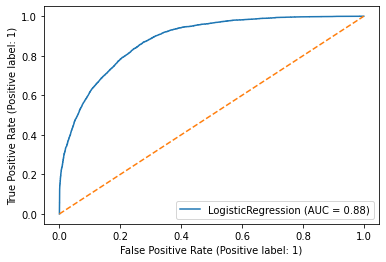

In [41]:
plot_roc_curve(model, X_train,y_train)
plt.plot([0, 1], [0, 1], linestyle='--');

In [ ]:
# Alternate code for roc curve.

# # predict probabilities
# probs = model.predict_proba(X_train)
# # keep probabilities for the positive outcome only
# probs = probs[:, 1]
# # calculate AUC
# auc = roc_auc_score(y_train, probs)
# print('AUC: %.3f' % auc)
# # calculate roc curve
# train_fpr, train_tpr, train_thresholds = roc_curve(y_train, probs)
# plt.plot([0, 1], [0, 1], linestyle='--')
# # plot the roc curve for the model
# plt.plot(train_fpr, train_tpr);

In [42]:
# Accuracy - Test Data
model.score(X_test, y_test)

0.8212234706616729

### AUC and ROC for the test data

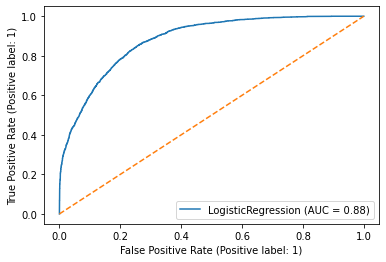

In [43]:
plot_roc_curve(model, X_test, y_test);
plt.plot([0,1],[0,1], linestyle='--');

In [ ]:
# # predict probabilities
# probs = model.predict_proba(X_test)
# # keep probabilities for the positive outcome only
# probs = probs[:, 1]
# # calculate AUC
# test_auc = roc_auc_score(y_test, probs)
# print('AUC: %.3f' % auc)
# # calculate roc curve
# test_fpr, test_tpr, test_thresholds = roc_curve(y_test, probs)
# plt.plot([0, 1], [0, 1], linestyle='--')
# # plot the roc curve for the model
# plt.plot(test_fpr, test_tpr);

### Confusion Matrix for the training data

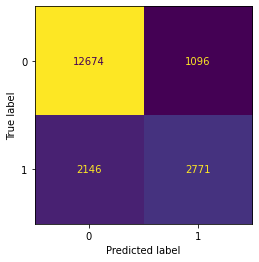

In [44]:
plot_confusion_matrix(model,X_train,y_train, colorbar=False);

In [45]:
print(classification_report(y_train, ytrain_predict))

              precision    recall  f1-score   support

           0       0.86      0.92      0.89     13770
           1       0.72      0.56      0.63      4917

    accuracy                           0.83     18687
   macro avg       0.79      0.74      0.76     18687
weighted avg       0.82      0.83      0.82     18687



### Confusion Matrix for test data

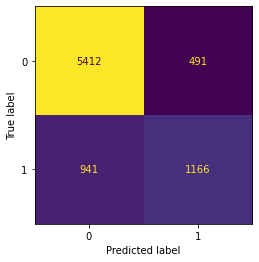

In [46]:
plot_confusion_matrix(model,X_test,y_test, colorbar=False);

In [47]:
print(classification_report(y_test, ytest_predict))

              precision    recall  f1-score   support

           0       0.85      0.92      0.88      5903
           1       0.70      0.55      0.62      2107

    accuracy                           0.82      8010
   macro avg       0.78      0.74      0.75      8010
weighted avg       0.81      0.82      0.81      8010



## Applying GridSearchCV for Logistic Regression

In [48]:
grid={'penalty':['l2','none','l1','elasticnet'],
      'solver':['sag','lbfgs','saga','newton-cg','liblinear'],
      'tol':[0.0001,0.00001], # 0.1, 0.01,0.001,
     'l1_ratio':[0.25,0.5,0.75]} #'max_iter':[100,1000,10000]

In [49]:
model = LogisticRegression(max_iter=10000,n_jobs=2,random_state=1)

In [51]:
grid_search = GridSearchCV(estimator = model, param_grid = grid, cv = 3,n_jobs=-1,scoring='f1')

In [ ]:
# We are not running this code in the mentor session as it will take around 2 hours to complete grid search with all the hyper parameter option we have given in the grid. we will directly skip to working with the best model parameters identified by this grid search earlier. when you get this notebook you can uncomment the below code and run it. Pl note it may take over 2 hours depending in the speed of your laptop.

# grid_search.fit(X_train, y_train)

Best hyper parameters based on Grid Search:

{'l1_ratio': 0.25, 'penalty': 'l2', 'solver': 'newton-cg', 'tol': 0.0001} 

In [ ]:
# you can uncomment and run the below 2 lines of code once you have finished running grid search

# print(grid_search.best_params_,'\n')
# print(grid_search.best_estimator_)

In [52]:
# best_model = grid_search.best_estimator_
best_model = LogisticRegression(max_iter=10000,n_jobs=2,random_state=1,
                               l1_ratio=0.25,penalty='l2',
                               solver='newton-cg', tol=0.0001)

In [53]:
best_model.fit(X_train,y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1317: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn("l1_ratio parameter is only used when penalty is "


LogisticRegression(l1_ratio=0.25, max_iter=10000, n_jobs=2, random_state=1,
                   solver='newton-cg')

In [54]:
# Prediction on the training set

ytrain_predict = best_model.predict(X_train)
ytest_predict = best_model.predict(X_test)

In [55]:
## Getting the probabilities on the test set

ytest_predict_prob=best_model.predict_proba(X_test)
pd.DataFrame(ytest_predict_prob).head()

,0,1
0,0.564122,0.435878
1,0.005709,0.994291
2,0.932618,0.067382
3,0.760958,0.239042
4,0.715670,0.284330


              precision    recall  f1-score   support

           0       0.86      0.92      0.89     13770
           1       0.72      0.56      0.63      4917

    accuracy                           0.83     18687
   macro avg       0.79      0.74      0.76     18687
weighted avg       0.82      0.83      0.82     18687
 



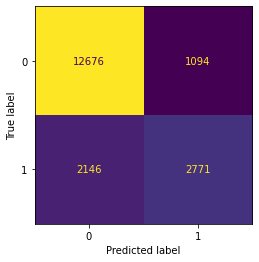

In [56]:
## Confusion matrix on the training data

plot_confusion_matrix(best_model,X_train,y_train, colorbar=False)
print(classification_report(y_train, ytrain_predict),'\n');

              precision    recall  f1-score   support

           0       0.85      0.92      0.88      5903
           1       0.70      0.55      0.62      2107

    accuracy                           0.82      8010
   macro avg       0.78      0.73      0.75      8010
weighted avg       0.81      0.82      0.81      8010
 



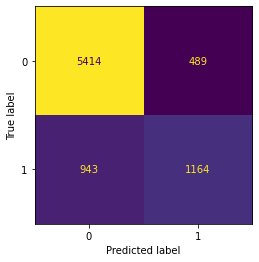

In [57]:
## Confusion matrix on the test data

plot_confusion_matrix(best_model,X_test,y_test, colorbar=False)
print(classification_report(y_test, ytest_predict),'\n');

You can select other (or more) parameters to perform GridSearchCV and try to optimize the desired parameter values and see if you are able to get a better model performance using such parameters.

Note: Alternatively, one hot encoding can also be done instead of label encoding on categorical variables before building the logistic regression model. Do play around with these techniques using one hot encoding as well.

Suggestions:


- **Education**: Reduce number of levels by clubbing together all school levels to a single level called 'schooling' etc
- **capital gains /loss** : convert it to a categorical feature with 2 levels - zero and non-zero, since more than 75% of values are zero and due to this all non -zero values are showing as outliers (since Q3=0, IQR=0, so the outlier limits are also zero)
- provide more options to GridSearchCV like solvers, penalty, tolerance (beware run time may take long or hang depending on your laptop configuration)
- Try different values of threshold probability instead of the default 0.5 to predict the '1' label of the target variable. We will learn how we can do this next week in the LDA session. Taking lower values of threshold probability increases the instances of '1' or positive class and would help improve the recall scores but precision scores will start dipping.

# Running in Google Colab
Importing jupyter notebook
1. Login to Google
2. Go to drive.google.com
3. Upload jupyter notebook file into the drive
4. double click it, or right click -&gt; open with -&gt; google colaboratory
Alternatively,
1. Login to Google
2. Go to https://colab.research.google.com/notebooks/intro.ipynb#recent=true
3. Upload the jupyter notebook

Loading dataset into colab
## Use the below code to load the dataset
from google.colab import files

uploaded = files.upload() # upload file here from local

import io

df2 = pd.read_csv(io.BytesIO(uploaded[&#39;Filename.csv&#39;])) #give the filename in quotes

Go to Runtime > change Runtime type > check if it points to Python

                                                    Happy Learning

In [58]:
best_model.coef_

array([[ 2.58249983e-02,  2.36285634e-01,  3.16172310e-04,
         6.79667664e-04,  5.08833369e-02, -2.53605502e-01,
        -5.21025677e-02,  2.18754867e+00,  4.22006303e-01,
         7.15304986e-01, -1.47722204e-01,  7.87753886e-01,
         2.93408337e-01]])